### FPF Gain approximation code

In [1]:
import numpy as np
from sympy import *
from scipy.spatial.distance import pdist,squareform
from scipy.stats import norm
import scipy.integrate as integrate

import pandas as pd
import math

from timeit import default_timer as timer

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ridge
%matplotlib inline

In [2]:
x = Symbol('x')

#### Function to approximate FPF gain using subspace RKHS method

In [3]:
def gain_rkhs_N(Xi, c, epsilon, Lambda, diag = 0):
    start = timer()
    
    N = len(Xi)
    K = np.zeros(N)
    Ker_x = np.array(np.zeros((N,N)))
    Ker_xy = np.array(np.zeros((N,N)))
    
    Ker = np.exp(- squareform(pdist(Xi,'euclidean'))**2/ (4 * epsilon))
    
    for i in range(N):
        for j in range(N):
            Ker_x[i,j] = -(Xi[i]-Xi[j]) * Ker[i,j] / (2 * epsilon)
    
    c_vec = lambdify(x, c, 'numpy')
    H = c_vec(Xi)
    eta = np.mean(H)
    Y = (H -eta)
    
    b_m = (1/ N) * np.dot(Ker,Y)
    M_m = Lambda * Ker + (1/ N) * np.matmul(Ker_x, Ker_x.transpose())
    beta_m = np.linalg.solve(M_m,b_m)
    
    K = np.zeros(N)
    for i in range(N):
        for j in range(N):
            K[i] = K[i] + beta_m[j] * Ker_x[i,j]
            
    if diag == 1:
        plt.figure()
        plt.plot(Xi, Ker[:,100],'r*')
        plt.plot(Xi, Ker_x[:,100], 'b*')
        plt.show()
            
    end = timer()
    print('Time taken' , end - start)
    
    return K

#### Function to approximate FPF gain using optimal RKHS method

In [4]:
def gain_rkhs_2N(Xi, c, epsilon, Lambda, diag = 0):
    start = timer()
    
    N = len(Xi)
    K = np.zeros(N)
    Ker_x = np.array(np.zeros((N,N)))
    Ker_xy = np.array(np.zeros((N,N)))
    
    Ker = np.exp(- squareform(pdist(Xi,'euclidean'))**2/ (4 * epsilon))
    for i in range(N):
        for j in range(N):
            Ker_x[i,j] = -(Xi[i]-Xi[j]) * Ker[i,j] / (2 * epsilon)
            Ker_xy[i,j] = -(((Xi[i] - Xi[j])**2) / (2 * epsilon) -1) * Ker[i,j] / (2 * epsilon) # Negative of the second Gaussian derivative, as this is K_xy and not K_x2
    
    c_vec = lambdify(x, c, 'numpy')
    H = c_vec(Xi)
    eta = np.mean(H)
    Y = (H -eta)
    
    # Constructing block matrices for future use
    # K_big      = [ Ker Ker_x ; Ker_x' Ker_x_y];
    # K_thin_yxy = [ Ker_x ; Ker_x_y]; 
    # K_thin_x   = [ Ker ; Ker_x'];
    K_big      = np.concatenate((np.concatenate((Ker,np.transpose(Ker_x)),axis = 1), np.concatenate((Ker_x, Ker_xy),axis =1)))
    K_thin_yxy = np.concatenate((np.transpose(Ker_x), Ker_xy))
    K_thin_xxy = np.concatenate((Ker_x,Ker_xy), axis = 1)
    K_thin_x   = np.concatenate((Ker, Ker_x))
    
    # b used in the extended representer theorem algorithm - searching over all of the Hilbert space H
    b_2m        = (1/N) * np.dot(K_thin_x, Y)
    M_2m        = Lambda * K_big + (1/N) * np.matmul(K_thin_yxy, np.transpose(K_thin_yxy))
    # M_2m        = Lambda * K_big + (1/N) * np.matmul(K_thin_yxy, K_thin_xxy)
    beta_2m     = np.linalg.solve(M_2m, b_2m)   
    
    K = np.zeros(N)
    for i in range(N):
        for j in range(N):
            K[i] = K[i] + beta_2m[j] * Ker_x[i,j] + beta_2m[N+j] * Ker_xy[i,j]
            
    if diag == 1:
        plt.figure()
        plt.plot(Xi, Ker[:,0],'r*')
        plt.plot(Xi, Ker_x[:,0], 'b*')
        plt.plot(Xi, Ker_xy[:,0],'k*')
        plt.show()
            
    end = timer()
    print('Time taken' , end - start)
    
    return K

#### Function to compute the exact FPF gain

In [5]:
def gain_exact(Xi, c, p, c_hat, diag = 0):
    start = timer()
    
    N = len(Xi)
    K = np.zeros(N)
    integral = np.zeros(N)
    
    step = 0.01
    xmax = max(mu) + 10
    
    p_vec = lambdify(x, p, 'numpy')
    c_vec = lambdify(x, c, 'numpy')
    H = c_vec(Xi)
    
    for i in range(N):
        integral[i] = 0
        for xj in np.arange(Xi[i], xmax + 10,  step):
            integral[i] = integral[i] + p_vec(xj) * ( c_vec(xj) - c_hat) * step
        K[i] = integral[i]/ p_vec(Xi[i])
            
    end = timer()
    print('Time taken' , end - start)
    return K

#### Function to approximate FPF gain using Markov kernel approx. method

In [6]:
def gain_coif(Xi, c, epsilon, Phi, diag = 0):
    start = timer()
    
    N = len(Xi)
    k = np.zeros((N,N))
    K = np.zeros(N)
    T = np.zeros((N,N))
    Phi = np.zeros(N)
    sum_term = np.zeros(N)
    max_diff = 1
    
    No_iterations = 50000
    iterations = 1
    
    c_vec = lambdify(x, c, 'numpy')
    H   = c_vec(Xi)
    
    Ker = np.exp(- squareform(pdist(Xi,'euclidean'))**2/ (4 * epsilon))
    for i in range(N):
        for j in range(N):
            k[i,j] = Ker[i,j] / (np.sqrt( (1/N) * sum(Ker[i,:])) * np.sqrt( (1/N)* sum(Ker[j,:])))
        T[i,:] = np.divide(k[i,:], np.sum(k[i,:]))
    
    while((max_diff > 1e-2) & ( iterations < No_iterations )):
        Phi_new = np.matmul(T,Phi) + (epsilon * np.concatenate(H)).transpose() 
        max_diff = max(Phi_new - Phi) - min(Phi_new - Phi)
        Phi  = Phi_new
        iterations += 1
                           
    for i in range(N):
        sum_term[i] = np.dot( T[i,:], Xi)
        K[i] = 0
        for j in range(N):
            K[i] = K[i] + (1/ (2 * epsilon)) * T[i,j] * Phi[j,] * (Xi[j] - sum_term[i]) 
                                               
    if diag == 1:
        plt.figure()
        plt.plot(Xi, Ker[1,:], 'r*')
        plt.show()
    
    end = timer()
    print('Time taken' , end - start)
    
    return K

#### Function to approximate FPF gain using RKHS OM method - Adds a Lagrangian parameter to make use of the constant gain approximation

In [7]:
def gain_rkhs_om(Xi, c, epsilon, Lambda, diag = 0):
    start = timer()
    
    N = len(Xi)
    K = np.zeros(N)
    Ker_x = np.array(np.zeros((N,N)))
    Ker_xy = np.array(np.zeros((N,N)))
    
    Ker = np.exp(- squareform(pdist(Xi,'euclidean'))**2/ (4 * epsilon))
    
    for i in range(N):
        for j in range(N):
            Ker_x[i,j] = -(Xi[i]-Xi[j]) * Ker[i,j] / (2 * epsilon)
            Ker_xy[i,j] = (((Xi[i] - Xi[j])**2) / (2 * epsilon) -1) * Ker[i,j] / (2 * epsilon)
    Ker_x_ones = np.dot(np.ones((1,N)), Ker_x)
   
    c_vec = lambdify(x, c, 'numpy')
    H = c_vec(Xi)
    eta = np.mean(H)
    Y = (H -eta)
    
    K_hat = np.mean(Y * Xi)
    
    b_m = (1/ N) * np.dot(Ker,Y) - (1/ N) * np.transpose(Ker_x_ones) * K_hat 
    b_m = np.append(b_m, np.zeros((1,1)))
    
    M_m = Lambda * Ker + (1 / N) * np.matmul(Ker_x, Ker_x.transpose()) 
    M_m = np.vstack((M_m, (1/N) * Ker_x_ones))
    M_m = np.hstack((M_m, np.transpose(np.append(Ker_x_ones,np.zeros((1,1)))).reshape(len(M_m),1)))
    
    beta_m = np.linalg.solve(M_m,b_m)
    
    K = np.zeros(N)
    K.fill(K_hat)
    for i in range(N):
        for j in range(N):
            K[i] = K[i] + beta_m[j] * Ker_x[i,j]
            
    if diag == 1:
        plt.figure()
        plt.plot(Xi, Ker[:,0],'r*')
        plt.plot(Xi, Ker_x[:,0], 'b*')
        plt.plot(Xi, Ker_xy[:,0],'k*')
        plt.show()
            
    end = timer()
    print('Time taken' , end - start)
    
    return K

#### Function to compute the mean square error in gain function approximation

In [8]:
def mean_squared_error(K_exact, K_approx, p):
    N = len(K_exact)
    p_vec = lambdify(x, p, 'numpy')
    mse = (1/N) * np.linalg.norm(K_exact - K_approx)**2
    # mse2 = np.sum(((K_exact - K_approx)**2) *np.concatenate(p_vec(Xi)))
    return mse

#### Main code execution

0
Time taken 6.246181702
Time taken 29.593171516
Time taken 1.699140467999996
Time taken 5.014451588
Time taken 2.9495702340000065
1
Time taken 15.608149325999996
Time taken 71.235719626
Time taken 1.6829289730000028
Time taken 3.8646939129999964
Time taken 2.560948367000009
2
Time taken 5.635512492000004
Time taken 33.26121165999999
Time taken 1.6294505489999835
Time taken 4.78805152000001
Time taken 4.032021852000014
3
Time taken 9.165554904000004
Time taken 61.22267640099997
Time taken 3.7465904989999785
Time taken 8.545480801999986
Time taken 5.854707004999966
4
Time taken 12.365990685999975
Time taken 62.33785879199996
Time taken 3.703561387000036
Time taken 8.488018335999982
Time taken 6.967824257000018
5
Time taken 12.563066380999999
Time taken 63.73553546699998
Time taken 3.696268676000045
Time taken 8.449664319000021
Time taken 6.186935624
6
Time taken 12.172985825000012
Time taken 62.54582724100004
Time taken 3.7518939249999903
Time taken 8.740138355999989
Time taken 5.621886

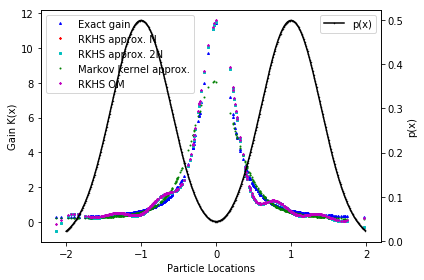

In [9]:
if __name__ == '__main__':
    
    ## Flags to be set to choose which methods to compare

    exact  = 1      # Computes the exact gain and plots 
    coif   = 1      # Computes gain using Coifman kernel method
    rkhs_N = 1      # Computes gain using subspace of RKHS
    rkhs_2N= 1      # Computes optimal gain using RKHS 
    om     = 1      # Computes gain using RKHS enforcing constant gain constraint
    memory = 0      # Computes gain using RKHS with a memory parameter for previous gain
    om_mem = 0      # Computes gain using const gain approx and a memory parameter for previous gain
    const  = 0      # Computes the constant gain approximation
    kalman = 0      # Runs Kalman Filter for comparison
    sis    = 0      # Runs Sequential Importance Sampling Particle Filter 

    # Run parameters
    No_runs = 10
    
    # FPF parameters - No. of particles
    N = 500
    
    # System parameters
    dim = 1     # dimension of the system
    c = x     # Observation function
    c_vec = lambdify(x, c, 'numpy')
        
    # Parameters of the prior density p(0) - 2 component Gaussian mixture density
    m = 2      # No of components in the Gaussian mixture
    sigma = [0.4, 0.4]
    mu  = [-1, 1]
    w   = [0.5, 0.5]
    w[-1] = 1 - sum(w[:-1])
    p = 0
    mu_eq = 0  # Equivalent mean of the density p
    for m in range(len(w)):
        p = p + w[m] * (1/ np.sqrt(2 * math.pi * sigma[m]**2))* exp(-(x - mu[m])**2/ (2* sigma[m]**2))
        mu_eq = mu_eq + w[m] * mu[m] 
    p_vec = lambdify(x, p, 'numpy')
    
    mse_coif = np.zeros(No_runs)
    mse_rkhs_N = np.zeros(No_runs)
    mse_rkhs_2N = np.zeros(No_runs)
    mse_om   = np.zeros(No_runs)
    for run in range(No_runs):
        print(run)
        Xi  = np.zeros((N,1))
        for i in range(N):
            if np.random.uniform() <= w[0]:
                Xi[i] = mu[0]  + sigma[0] * np.random.normal()
            else:
                Xi[i]  = mu[1]  + sigma[0] * np.random.normal()
# To check consistency with Matlab code output - using the same samples 
#         Xi = np.loadtxt('Xi.txt')
#         Xi = np.sort(Xi,kind = 'mergesort')
#         Xi = np.reshape(Xi,(-1,1))
#         plt.figure()
#         sns.distplot(Xi)
#         plt.show()

        if exact == 1:
            c_hat = mu_eq   # True only for c = x, linear function
            K_exact  = gain_exact(Xi, c, p, c_hat, diag = 0)

        if coif ==1:
            eps_coif = 0.1
            Phi = np.zeros(N)
            K_coif = gain_coif(Xi, c, eps_coif, Phi, diag = 0)
            if exact == 1:
                mse_coif[run] = mean_squared_error(K_exact, K_coif, p)

        if rkhs_N == 1:
            eps_rkhs_N = 0.1
            Lambda_rkhs_N = 1e-3
            K_rkhs_N = gain_rkhs_N(Xi, c, eps_rkhs_N, Lambda_rkhs_N, diag = 0)
            if exact == 1:
                mse_rkhs_N[run] = mean_squared_error(K_exact, K_rkhs_N, p)

        if rkhs_2N == 1:
            eps_rkhs_2N = 0.1
            Lambda_rkhs_2N = 1e-3
            K_rkhs_2N = gain_rkhs_2N(Xi, c, eps_rkhs_2N, Lambda_rkhs_2N, diag = 0)
            if exact == 1:
                mse_rkhs_2N[run] = mean_squared_error(K_exact, K_rkhs_2N, p)

        if om == 1:
            eps_om = 0.1
            Lambda_om = 1e-3
            K_om = gain_rkhs_om(Xi, c, eps_om, Lambda_om, diag = 0)
            if exact == 1:
                mse_om[run] = mean_squared_error(K_exact, K_om, p)
    
    if exact == 1 & coif == 1:
        print('MSE for Markov kernel approx', np.mean(mse_coif))
    if exact == 1 & rkhs_N == 1:
        print('MSE for RKHS N', np.mean(mse_rkhs_N))
    if exact == 1 & rkhs_2N == 1:
        print('MSE for RKHS 2N', np.mean(mse_rkhs_2N))
    if exact == 1 & om == 1:
        print('MSE for RKHS OM', np.mean(mse_om))
    
    ### Displaying the plots
    fig,ax1 = plt.subplots()
    if exact == 1:
        ax1.plot(Xi, K_exact, 'b^', markersize = 2, label ='Exact gain')
    if rkhs_N == 1:
        ax1.plot(Xi, K_rkhs_N, 'r*', markersize =2, label = 'RKHS approx. N')
    if rkhs_2N == 1:
        ax1.plot(Xi, K_rkhs_2N, 'cs', markersize =2, label = 'RKHS approx. 2N')
    if coif == 1:
        ax1.plot(Xi, K_coif, 'g.', markersize = 2, label ='Markov kernel approx.')
    if om == 1:
        ax1.plot(Xi, K_om, 'm*', markersize = 2, label = 'RKHS OM')
    ax2 =ax1.twinx()
    ax2.plot(np.arange(-2,2,0.01), p_vec(np.arange(-2,2,0.01)),'k.-', markersize =1, label = 'p(x)')
    ax2.set_ylabel('p(x)')
    ax2.legend(loc=1)
    ax1.set_xlabel('Particle Locations')
    ax1.set_ylabel('Gain K(x)')
    ax1.legend()
    plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.show()     

In [16]:
mse_rkhs_2N

array([0.20474018, 0.43195612, 0.30885522, 0.27550685, 0.37012747,
       0.10071576, 0.17313446, 0.32887822, 0.24304982, 0.08506073])

In [17]:
mse_rkhs_N

array([0.2047403 , 0.43195606, 0.30885523, 0.27550685, 0.37012747,
       0.10071576, 0.17313445, 0.32887822, 0.24304982, 0.08506073])

In [14]:
mse_coif

array([0.18233795, 0.36179269, 0.51424742, 0.24112596, 0.09748179,
       0.17267306, 0.07605512, 0.33844005, 0.35862283, 0.10523528])

### Rough trials